# Hyperparameters Database - Melbourne Housing Market

# Abstract

In every algorithm there are parameters and hyperparameters. A model parameter is a configuration variable that is internal to the model and whose value can be estimated from the given data. They are required by the models to make predictions.
A model hyperparameter is a configuration that is external to the model and whose value cannot be estimated from data. They are usually using heuristics for a given predictive model. The goal of this skunkworks project is to find the best hyperparameters for the models which were given by running H2O AutoML and create a database by running millions of hyperparameter values, over thousands of datasets and calculating the individual conditional expectation of every hyperparameter on the quality of a model. The objective is to create a database which has algorithms, tools and data that allows users to choose hyperparameters that maximize the predictive power of their respective models.

# Dataset

The original dataset for Melbourne Housing Market can be found on https://www.kaggle.com/anthonypino/melbourne-housing-market#Melbourne_housing_FULL.csv. From this datset we can find a trend or give a prediction for which suburbs are the best to buy in? Which ones are value for money? Where's the expensive side of town? This dataset consists of several features from which we make use to predict the prices of houses.

#### Features in our dataset:

1. Suburb: Suburb

2. Address: Address

3. Rooms: Number of rooms

4. Price: Price in Australian dollars

5. Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not     disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction       price not disclosed. N/A - price or highest bid not available.

6. Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; 
  o res - other residential.

7. SellerG: Real Estate Agent

8. Date: Date sold

9. Distance: Distance from CBD in Kilometres

10. Regionname: General Region (West, North West, North, North east ...etc)

11. Propertycount: Number of properties that exist in the suburb.

12. Bedroom2 : Scraped # of Bedrooms (from different source)

13. Bathroom: Number of Bathrooms

14. Car: Number of carspots

15. Landsize: Land Size in Metres

16. BuildingArea: Building Size in Metres

17. YearBuilt: Year the house was built

18. CouncilArea: Governing council for the area

#### Aim of the project:

1. Identify the type of dataset - Regression/Classification(Regression is our dataset type)
2. Perform data cleaning and pre-processing
3. Run H2O to get the models for different run times
4. Get the leaderboard and save all models on leaderboard in json files for all 5 run times
5. Save metadata for each run time
6. Extract and save parameters of all models for every run time
7. Find the important hyperparameters for models
8. Find the range of hyperparameters for models
9. Compare the range of values across the models for different hyperparameters

#### Importing required libraries

In [8]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import logging
import csv
import optparse
import seaborn as sns
import time
import json
from distutils.util import strtobool
import psutil
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

#### Initializing meta data values

In [2]:
data_path=None
all_variables=None
test_path=None
target=None
nthreads=1                        
min_mem_size= 5 
classification= False
scale=False
max_models=None    
model_path=None
balance_y=False 
balance_threshold=0.2             
name=None 
server_path=None  
analysis=0

#### Importing the dataset using pandas

In [3]:
data_path = 'D:\DATASCIENCE\My Practice\Melbourne_housing_FULL.csv'

In [9]:
df = pd.read_csv('D:\DATASCIENCE\My Practice\Melbourne_housing_FULL.csv')

In [1]:
# Setting up the run-time for 500 sec
run_time= 500

In [6]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size, "GB")

2 GB


In [7]:
#Defining functions

#generating random run_id
def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str

# storing in meta-data in dictionary  
def set_meta_data(analysis,run_id,server,data,model_path,run_time,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['max_models']=model
  m_data['start_time'] = time.time()
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['max_models']=model 
  m_data['scale']=scale  
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()  
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data

#converting dictionary to json
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
# Segregating in different lists of int, enum, reals and checking for missing values and then scaling(standardizing)    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return

# Determining Independent variables (X) from the dataset 
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

#Checkinh if X does not exist then remove
def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x


In [9]:
#randomly generating run_id through alphabet function
run_id=alphabet(9)
if server_path==None:
    server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

MMMhIC8Po


In [10]:
name = run_id+'_Melbournehousingprices_500'
name

'MMMhIC8Po_Melbournehousingprices_500'

In [11]:
df.shape

(34857, 21)

#### Viewing our dataset

In [12]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [10]:
#Printing object columns
print(df.select_dtypes(['object']).columns)

Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea',
       'Regionname'],
      dtype='object')


In [11]:
obj_cats = ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'CouncilArea','Regionname']
#Converting object columns to categories
for colname in obj_cats:
    df[colname] = df[colname].astype('category')

#### Viewing correlation between all variables

Text(0.5, 1.0, 'Variable Correlation')

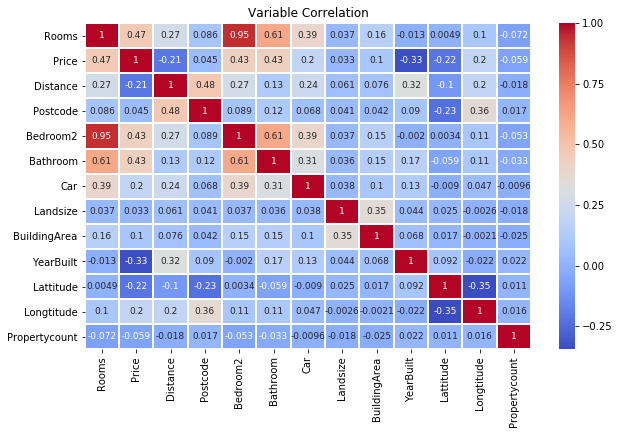

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),cmap = 'coolwarm',linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

#### Dropping the Bedroom2 column as Rooms and Bedroom2 have same values and correlation between them is also very high

In [14]:
df = df.drop(columns=['Bedroom2'])

In [15]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


#### Checking for null values

In [15]:
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

#### Dropping the rows which has price values as null

In [16]:
df = df.dropna(subset=['Price'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 20 columns):
Suburb           27247 non-null category
Address          27247 non-null category
Rooms            27247 non-null int64
Type             27247 non-null category
Price            27247 non-null float64
Method           27247 non-null category
SellerG          27247 non-null category
Date             27247 non-null object
Distance         27246 non-null float64
Postcode         27246 non-null float64
Bathroom         20800 non-null float64
Car              20423 non-null float64
Landsize         17982 non-null float64
BuildingArea     10656 non-null float64
YearBuilt        12084 non-null float64
CouncilArea      27244 non-null category
Lattitude        20993 non-null float64
Longtitude       20993 non-null float64
Regionname       27244 non-null category
Propertycount    27244 non-null float64
dtypes: category(7), float64(11), int64(1), object(1)
memory usage: 4.8+ MB


#### Dropping the rows in which Distance, Postcode, CouncilArea, Regionname, Propertycount have null values as they have 2 null values in their column and also converting data datatype to datetime

In [18]:
df = df.dropna(subset=['Distance','Postcode','CouncilArea','Regionname','Propertycount'])
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27244 entries, 1 to 34856
Data columns (total 20 columns):
Suburb           27244 non-null category
Address          27244 non-null category
Rooms            27244 non-null int64
Type             27244 non-null category
Price            27244 non-null float64
Method           27244 non-null category
SellerG          27244 non-null category
Date             27244 non-null datetime64[ns]
Distance         27244 non-null float64
Postcode         27244 non-null float64
Bathroom         20800 non-null float64
Car              20423 non-null float64
Landsize         17982 non-null float64
BuildingArea     10656 non-null float64
YearBuilt        12084 non-null float64
CouncilArea      27244 non-null category
Lattitude        20993 non-null float64
Longtitude       20993 non-null float64
Regionname       27244 non-null category
Propertycount    27244 non-null float64
dtypes: category(7), datetime64[ns](1), float64(11), int64(1)
memory usage: 4.8

#### Filling the rest of the numeric columns null values with mean

In [20]:
for cols in df.columns:
    if df[cols].isnull().sum() != 0:
        df[cols].fillna((df[cols].mean()), inplace=True)
        
df.isnull().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27244 entries, 1 to 34856
Data columns (total 20 columns):
Suburb           27244 non-null category
Address          27244 non-null category
Rooms            27244 non-null int64
Type             27244 non-null category
Price            27244 non-null float64
Method           27244 non-null category
SellerG          27244 non-null category
Date             27244 non-null datetime64[ns]
Distance         27244 non-null float64
Postcode         27244 non-null float64
Bathroom         27244 non-null float64
Car              27244 non-null float64
Landsize         27244 non-null float64
BuildingArea     27244 non-null float64
YearBuilt        27244 non-null float64
CouncilArea      27244 non-null category
Lattitude        27244 non-null float64
Longtitude       27244 non-null float64
Regionname       27244 non-null category
Propertycount    27244 non-null float64
dtypes: category(7), datetime64[ns](1), float64(11), int64(1)
memory usage: 4.8

#### Checking whether BuildingArea or Landsize is zero If zero we remove those rows as without them there is no house

In [22]:
print(df[df['BuildingArea']==0])
print(df[df['Landsize']==0])

                 Suburb              Address  Rooms Type      Price Method  \
7211    North Melbourne         19 Shands La      2    t   841000.0      S   
19775      Balwyn North        14 Wanbrow Av      5    h  1950000.0      S   
19840          Bundoora        22 Moreton Cr      3    h   814000.0      S   
20223     Roxburgh Park       16 Sandover Dr      4    h   570000.0      S   
20262         Thornbury    19/337 Station St      3    t   900000.0     VB   
21155            Elwood        6/31 Beach Av      2    u   735000.0      S   
21561     Sunshine West          5 Comino Rd      5    h   720000.0      S   
21742    Brunswick West     10/13 Peacock St      2    u   461500.0     SP   
21858          Essendon      6/4 Balmoral St      2    u   491000.0      S   
21954               Kew  9/910 Glenferrie Rd      2    u  1005000.0      S   
22040           Prahran        6 Aberdeen Rd      3    h  1390000.0      S   
22507       Huntingdale       33 Beauford St      3    h  120500

[61 rows x 20 columns]
               Suburb                Address  Rooms Type      Price Method  \
17         Abbotsford     6/241 Nicholson St      1    u   300000.0      S   
23         Abbotsford     411/8 Grosvenor St      2    u   700000.0     VB   
25         Abbotsford    123/56 Nicholson St      2    u   750000.0      S   
29         Abbotsford     7/20 Abbotsford St      1    u   441000.0     SP   
40         Abbotsford     13/11 Nicholson St      3    t   900000.0      S   
42         Abbotsford     6/219 Nicholson St      2    u   500000.0      S   
48         Abbotsford     5/20 Abbotsford St      1    u   426000.0     SP   
50         Abbotsford    116/56 Nicholson St      1    u   457000.0      S   
53         Abbotsford           31 Turner St      4    h  1542000.0      S   
57         Abbotsford        11/205 Gipps St      1    u   470000.0      S   
67       Airport West          50 Bedford St      3    h   730000.0     VB   
68       Airport West          50 Bedford

[1942 rows x 20 columns]


In [23]:
df = df[df['BuildingArea']!=0]
df = df[df['Landsize']!=0]

In [24]:
df.describe()

,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,25241.000000,2.524100e+04,25241.000000,25241.000000,25241.000000,25241.000000,25241.000000,25241.000000,25241.000000,25241.000000,25241.000000,25241.000000
mean,3.070124,1.081375e+06,11.652827,3114.160691,1.618906,1.760671,639.131934,160.254982,1965.985712,-37.805641,144.997394,7513.653738
std,0.925769,6.478327e+05,6.828392,113.858492,0.612034,0.863154,3166.505912,291.014251,24.450405,0.081988,0.108869,4513.568728
min,1.000000,1.120000e+05,0.000000,3000.000000,0.000000,0.000000,1.000000,1.000000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.600000e+05,6.900000,3046.000000,1.000000,1.000000,459.000000,156.834586,1966.609153,-37.840320,144.954190,4217.000000
50%,3.000000,9.000000e+05,10.700000,3087.000000,1.591683,1.715370,593.488933,156.834586,1966.609153,-37.806963,144.996711,6543.000000
75%,4.000000,1.317000e+06,14.300000,3152.000000,2.000000,2.000000,605.000000,156.834586,1966.609153,-37.763400,145.051750,10331.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,9.000000,18.000000,433014.000000,44515.000000,2019.000000,-37.397800,145.526350,21650.000000


#### Looking at the distribution of price data

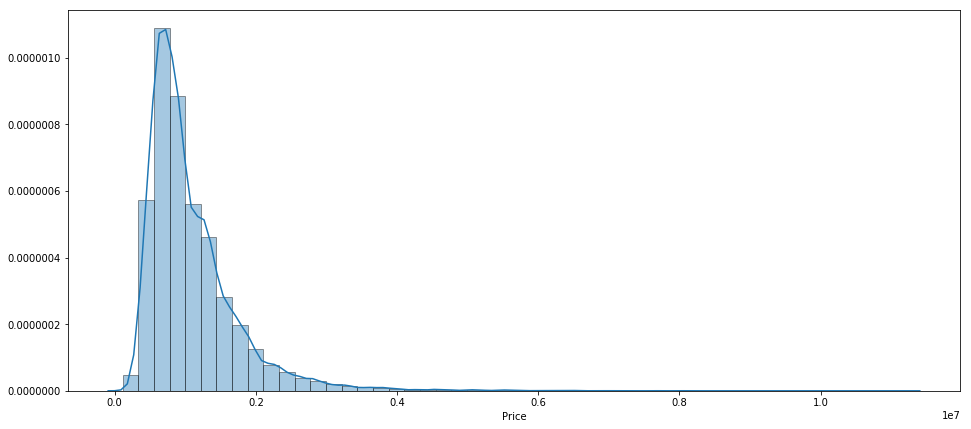

In [25]:
plt.figure(figsize=(16,7))
sns.distplot(df['Price'], kde = True,hist_kws=dict(edgecolor="k"))

# H2O

H2O is open-source software for big-data analysis. It is produced by the company H2O.ai. H2O allows users to fit thousands of potential models as part of discovering patterns in data. In this project we used H2OAutoMl to generate models as it does hyperparameter tuning for all those models in given time. It relieves us from some burden in creating different models manually and tuning the hyperparameters for those models.

H2O from Python is a tool for rapidly turning over models, doing data munging, and building applications in a fast, scalable environment without any of the mental anguish about parallelism and distribution of work.

#### Initializing H2O

In [26]:
import h2o
h2o.init(max_mem_size="5G")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\venu0\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\venu0\AppData\Local\Temp\tmp6ju900en
  JVM stdout: C:\Users\venu0\AppData\Local\Temp\tmp6ju900en\h2o_venu0_started_from_python.out
  JVM stderr: C:\Users\venu0\AppData\Local\Temp\tmp6ju900en\h2o_venu0_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.6
H2O cluster version age:,1 month and 7 days
H2O cluster name:,H2O_from_python_venu0_szhwy9
H2O cluster total nodes:,1
H2O cluster free memory:,4.445 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [27]:
print(data_path) 

D:\DATASCIENCE\My Practice\Melbourne_housing_FULL.csv


In [28]:
# setting meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,model_path,run_time,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'run_time': 500, 'run_id': 'MMMhIC8Po', 'max_models': None, 'start_time': 1555878612.4794712, 'server_path': 'C:\\Users\\venu0', 'data_path': 'D:\\DATASCIENCE\\My Practice\\Melbourne_housing_FULL.csv', 'scale': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': 'MMMhIC8Po_Melbournehousingprices_500', 'end_time': 1555878612.4794712, 'run_path': 'C:\\Users\\venu0\\MMMhIC8Po', 'nthreads': 1, 'min_mem_size': 2, 'analysis': 0}


In [29]:
dd = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [30]:
dd.head()

Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
Abbotsford,68 Studley St,2,h,nan,SS,Jellis,3/09/2016,2.5,3067,2,1,1,126,nan,nan,Yarra City Council,-37.8014,144.996,Northern Metropolitan,4019
Abbotsford,85 Turner St,2,h,1.48e+06,S,Biggin,3/12/2016,2.5,3067,2,1,1,202,nan,nan,Yarra City Council,-37.7996,144.998,Northern Metropolitan,4019
Abbotsford,25 Bloomburg St,2,h,1.035e+06,S,Biggin,4/02/2016,2.5,3067,2,1,0,156,79,1900,Yarra City Council,-37.8079,144.993,Northern Metropolitan,4019
Abbotsford,18/659 Victoria St,3,u,nan,VB,Rounds,4/02/2016,2.5,3067,3,2,1,0,nan,nan,Yarra City Council,-37.8114,145.012,Northern Metropolitan,4019
Abbotsford,5 Charles St,3,h,1.465e+06,SP,Biggin,4/03/2017,2.5,3067,3,2,0,134,150,1900,Yarra City Council,-37.8093,144.994,Northern Metropolitan,4019
Abbotsford,40 Federation La,3,h,850000,PI,Biggin,4/03/2017,2.5,3067,3,2,1,94,nan,nan,Yarra City Council,-37.7969,144.997,Northern Metropolitan,4019
Abbotsford,55a Park St,4,h,1.6e+06,VB,Nelson,4/06/2016,2.5,3067,3,1,2,120,142,2014,Yarra City Council,-37.8072,144.994,Northern Metropolitan,4019
Abbotsford,16 Maugie St,4,h,nan,SN,Nelson,6/08/2016,2.5,3067,3,2,2,400,220,2006,Yarra City Council,-37.7965,144.996,Northern Metropolitan,4019
Abbotsford,53 Turner St,2,h,nan,S,Biggin,6/08/2016,2.5,3067,4,1,2,201,nan,1900,Yarra City Council,-37.7995,144.997,Northern Metropolitan,4019
Abbotsford,99 Turner St,2,h,nan,S,Collins,6/08/2016,2.5,3067,3,2,1,202,nan,1900,Yarra City Council,-37.7996,144.999,Northern Metropolitan,4019


#### Dataset Information

In [31]:
rows = len(dd)
print("Total rows in the data set = ", rows)
cols = len(dd.columns)
print("Total Columns in the data set = ", cols)

rowscols = dd.shape
shape = rows * cols
print("rows X columns = ", rowscols)
print("Total Records = ", shape)

meta_data['Total Records'] = shape

Total rows in the data set =  34857
Total Columns in the data set =  21
rows X columns =  (34857, 21)
Total Records =  731997


In [32]:
dd.describe()

Rows:34857
Cols:21




,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
type,enum,string,int,enum,int,enum,enum,enum,real,int,int,int,int,int,real,int,enum,real,real,enum,int
mins,,NaN,1.0,,85000.0,,,,0.0,3000.0,0.0,0.0,0.0,0.0,0.0,1196.0,,-38.19043,144.42379,,83.0
mean,,NaN,3.0310124221820587,,1050173.344955408,,,,11.18492942391554,3116.062858618315,3.0846471471471473,1.6247981675490963,1.7288453442535114,593.5989933613921,160.25640035657105,1965.2898848948619,,-37.81063429559912,145.00185113165432,,7572.8883055029555
maxs,,NaN,16.0,,11200000.0,,,,48.1,3978.0,30.0,12.0,26.0,433014.0,44515.0,2106.0,,-37.3902,145.52635,,21650.0
sigma,,NaN,0.9699329348975164,,641467.1301046001,,,,6.788892455935928,109.02390274290644,0.980689728546156,0.7242120114699064,1.010770785355424,3398.84194645991,401.26706008485496,37.3281780231362,,0.09027890450922342,0.12016876915351837,,4428.090313274636
zeros,,0,0,,0,,,,77,0,17,46,1631,2437,76,0,,0,0,,0
missing,0,0,0,0,7610,0,0,0,1,1,8217,8226,8728,11810,21115,19306,0,7976,7976,0,3
0,Abbotsford,68 Studley St,2.0,h,nan,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,nan,nan,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2.0,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,nan,nan,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2.0,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0


In [33]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
    target="Price"   
y = target
meta_data['Target']=y
y

'Price'

In [34]:
if all_variables is not None:
  ivd=get_all_variables_csv(all_variables)
  print(ivd)    
  X=check_all_variables(dd,ivd,y)
  print(X)

In [35]:
# independent variables
# putting all independent variables in the list X 

X = []  
if all_variables is None:
  X=get_independent_variables(dd, target)  
  print(X)  
else: 
  ivd=get_all_variables_csv(all_variables)    
  X=check_all_variables(dd, ivd)


X=check_X(X,dd)


# Add independent variables to meta data

meta_data['X']=X  


# impute missing values

_=impute_missing_values(dd,X, scale)

['Rooms', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'Propertycount', 'Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname', 'Address', 'Distance', 'BuildingArea', 'Lattitude', 'Longtitude']


In [36]:
def get_variables_types(dd):
    d={}
    for key, val in dd.types.items():
        d[key]=val           
    return d

#### Viewing all variables and their datatypes in the dataset

In [37]:
allV=get_variables_types(dd)
allV

{'Suburb': 'enum',
 'Address': 'string',
 'Rooms': 'int',
 'Type': 'enum',
 'Price': 'int',
 'Method': 'enum',
 'SellerG': 'enum',
 'Date': 'enum',
 'Distance': 'real',
 'Postcode': 'int',
 'Bedroom2': 'int',
 'Bathroom': 'int',
 'Car': 'int',
 'Landsize': 'int',
 'BuildingArea': 'real',
 'YearBuilt': 'int',
 'CouncilArea': 'enum',
 'Lattitude': 'real',
 'Longtitude': 'real',
 'Regionname': 'enum',
 'Propertycount': 'int'}

In [38]:
# Adding the data types to meta data 
meta_data['variables']=allV

In [39]:
#Converting pandas dataframe to H2OFrame
data = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [40]:
# Splitting the data into train and test in ratio 80:20
train,test = data.split_frame(ratios=[0.8],seed=123)

In [41]:
x = ["Suburb","Address","Rooms","Type","Method","SellerG","Date","Distance","Postcode","Bathroom","Car","Landsize","BuildingArea","YearBuilt","CouncilArea","Lattitude","Longtitude","Regionname","Propertycount"]
y = "Price"

#### Importing AutoML from H2O and running it on our training data for 500 sec

In [42]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=500)

In [43]:
model_start_time = time.time()

In [44]:
aml.train(x=x,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [45]:
execution_time =  time.time() - model_start_time
meta_data['model_execution_time_sec'] = execution_time
print("Execution time for ", run_time,"sec =  ",meta_data['model_execution_time_sec'])

Execution time for  500 sec =   522.2220416069031


In [46]:
#Leaderboard of automl
lb1 = aml.leaderboard.as_data_frame()
lb1

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,GBM_3_AutoML_20190421_163021,9.081250e+10,301351.125810,9.081250e+10,170550.869103,0.203279
1,GBM_1_AutoML_20190421_163021,9.274378e+10,304538.633399,9.274378e+10,172231.013768,0.205784
2,GBM_4_AutoML_20190421_163021,9.310483e+10,305130.848247,9.310483e+10,172461.276148,0.205500
3,GBM_2_AutoML_20190421_163021,9.331892e+10,305481.451554,9.331892e+10,172240.396608,0.205469
4,GBM_5_AutoML_20190421_163021,9.731804e+10,311958.392813,9.731804e+10,176273.941817,0.209602
5,DRF_1_AutoML_20190421_163021,9.814160e+10,313275.593139,9.814160e+10,174763.703428,0.207246
6,DeepLearning_1_AutoML_20190421_163021,1.040603e+11,322583.788780,1.040603e+11,188843.098879,0.226461
7,XRT_1_AutoML_20190421_163021,1.045688e+11,323371.006725,1.045688e+11,182539.055996,0.217306
8,DeepLearning_grid_1_AutoML_20190421_163021_mod...,1.220920e+11,349416.607698,1.220920e+11,195650.298580,NaN
9,GBM_grid_1_AutoML_20190421_163021_model_1,1.375282e+11,370847.962741,1.375282e+11,229302.022817,NaN


In [47]:
length = len(lb1)- 1
length
meta_data["Models_generated"] = length

In [48]:
# save leaderboard to csv
# run_time = run_time.ascharacter()
leaderboard_stats=run_id+'Melbournehousingprices_500' + '_leaderboard.csv'
lb1.to_csv(leaderboard_stats)

In [49]:
# Start best model as first model
model_set=lb1['model_id']
mod_best=h2o.get_model(model_set[0])

In [50]:
# Best model parameters
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_20190421_163021',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_20190421_163021'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_py_6_sid_9444',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_py_6_sid_9444'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default

In [51]:
# Applying the best model from leaderboard on test data to check how well it performs
aml.leader.model_performance(test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 77313903372.18051
RMSE: 278053.77784195007
MAE: 168585.7393777483
RMSLE: 0.19976934601251925
Mean Residual Deviance: 77313903372.18051


In [52]:
# generating normalized coeff.
mods=mod_best.coef_norm
print(mods)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20190421_163021


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 36806519107.27184
RMSE: 191850.25177797355
MAE: 113404.91357294285
RMSLE: 0.14030437553104919
Mean Residual Deviance: 36806519107.27184

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 90812501027.05182
RMSE: 301351.1258101616
MAE: 170550.86910283403
RMSLE: 0.20327946314367926
Mean Residual Deviance: 90812501027.05182
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,170551.1,1652.4524,170930.1,166747.39,169277.36,172769.86,173030.8
mean_residual_deviance,90812965000.0000000,6056043500.0000000,88146600000.0000000,75361845000.0000000,99533234000.0000000,96108618000.0000000,94914527000.0000000
mse,90812965000.0000000,6056043500.0000000,88146600000.0000000,75361845000.0000000,99533234000.0000000,96108618000.0000000,94914527000.0000000
r2,0.7858837,0.0132028,0.7911847,0.8132027,0.7553251,0.7888996,0.7808061
residual_deviance,90812965000.0000000,6056043500.0000000,88146600000.0000000,75361845000.0000000,99533234000.0000000,96108618000.0000000,94914527000.0000000
rmse,301000.16,10292.309,296894.94,274521.12,315488.88,310013.9,308082.0
rmsle,0.2032430,0.0027211,0.2092361,0.1971777,0.2037492,0.2023235,0.2037287


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-21 16:35:05,12.337 sec,0.0,651357.1415074,456747.0382373,424266125792.6755371
,2019-04-21 16:35:05,12.475 sec,5.0,465788.1989384,312938.8394838,216958646270.3200073
,2019-04-21 16:35:05,12.605 sec,10.0,358374.8302365,229491.2872603,128432518947.0731659
,2019-04-21 16:35:05,12.732 sec,15.0,300089.6056078,185734.0172836,90053771393.8685608
,2019-04-21 16:35:05,12.831 sec,20.0,270123.2701300,163258.9679658,72966581065.7311401
,2019-04-21 16:35:05,12.923 sec,25.0,251273.1984269,149876.8110856,63138220247.6763306
,2019-04-21 16:35:05,12.995 sec,30.0,237721.7205580,140760.5216591,56511616425.0643158
,2019-04-21 16:35:06,13.111 sec,35.0,226826.8661772,133994.7532578,51450427219.7613220
,2019-04-21 16:35:06,13.272 sec,40.0,218788.3252344,129029.8965736,47868331258.8781967
,2019-04-21 16:35:06,13.411 sec,45.0,212049.2641296,124935.6149354,44964890417.9219055


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Suburb,13274966522855424.0000000,1.0,0.3607272
Rooms,6149220104929280.0000000,0.4632193,0.1670958
SellerG,5149062344998912.0000000,0.3878776,0.1399180
Type,3433937485430784.0000000,0.2586777,0.0933121
CouncilArea,1847282345443328.0000000,0.1391553,0.0501971
Regionname,1386063255830528.0000000,0.1044118,0.0376642
Landsize,1108398451982336.0000000,0.0834954,0.0301191
Bathroom,912980124368896.0000000,0.0687746,0.0248089
BuildingArea,840195796631552.0000000,0.0632917,0.0228311
Distance,557112086233088.0000000,0.0419671,0.0151387


<bound method ModelBase.coef_norm of >


In [53]:
model_set=lb1['model_id']
type(model_set)

pandas.core.series.Series

#### Creating a dictionary and appending all the models hyperparameters in A json file

In [54]:
jsonDicts = []
for m in model_set.iteritems():
    m,model_name = m
    mod_best = h2o.get_model(model_name)
    jsonDicts.append(mod_best.params)

In [56]:
n=run_id+'MelbourneHousingPrices_500_hy_parameter.json'
dict_to_json(jsonDicts,n)

In [57]:
meta_data['end_time'] = time.time()

In [58]:
meta_data

{'run_time': 500,
 'run_id': 'MMMhIC8Po',
 'max_models': None,
 'start_time': 1555878612.4794712,
 'server_path': 'C:\\Users\\venu0',
 'data_path': 'D:\\DATASCIENCE\\My Practice\\Melbourne_housing_FULL.csv',
 'scale': False,
 'model_path': None,
 'balance': False,
 'balance_threshold': 0.2,
 'project': 'MMMhIC8Po_Melbournehousingprices_500',
 'end_time': 1555879144.1498828,
 'run_path': 'C:\\Users\\venu0\\MMMhIC8Po',
 'nthreads': 1,
 'min_mem_size': 2,
 'analysis': 0,
 'Total Records': 731997,
 'Target': 'Price',
 'X': ['Rooms',
  'Postcode',
  'Bedroom2',
  'Bathroom',
  'Car',
  'Landsize',
  'YearBuilt',
  'Propertycount',
  'Suburb',
  'Type',
  'Method',
  'SellerG',
  'Date',
  'CouncilArea',
  'Regionname',
  'Address',
  'Distance',
  'BuildingArea',
  'Lattitude',
  'Longtitude'],
 'variables': {'Suburb': 'enum',
  'Address': 'string',
  'Rooms': 'int',
  'Type': 'enum',
  'Price': 'int',
  'Method': 'enum',
  'SellerG': 'enum',
  'Date': 'enum',
  'Distance': 'real',
  'Postc

In [59]:
# Saving meta data in json format
n=run_id+'MelbHousingPrices_500_meta_data.json'
dict_to_json(meta_data,n)

#### Plotting a graph of variable importance for the best model in leaderboard

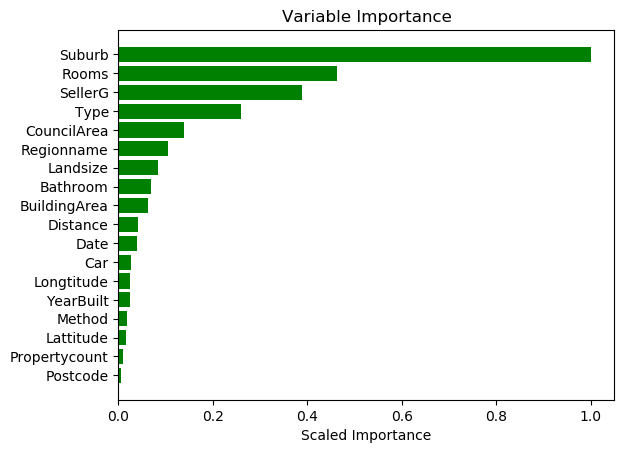

In [66]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = aml.leader._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = aml.leader._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

# Conclusion

Inorder to find the best hyperparameter,we run the H2O AutoML for different runtimes. H2O AutoML not only provides best model for dataset but also provide list's of information like Evaluation Metrics, parameters and hyperparameters of each model. We ran H2O AutoML for 5 different runtimes and we compared the values of their Hyperparameters and analysed the range across models for all 5 runtimes.We have compared the hyperparamerers with the metrics inorder to check which particular hyperparameter is haveing a large effecton the metric.We have plotted plots to visuvalize the same. We have analyzed the best hyperparameters for each model which are effecting the model's outcome.

For our dataset the The GBM model worked very well with a good RMSE rate of 300602.2988 at a runtime of 1300 seconds.The most important hyperparameters are ntrees ,max_depth  ,sample_rate ,col_sample_rate_per_tree ,min_split_improvement ,learn_rate ,col_sample_rate. We have also observed that most of the models performed well with the increase in runtime

# Contribution

In above analysis:

1. 70% of explanation, analysis and code is done by us.
2. 20% of resource is from web and citations are given below.
3. 10% of resource is from prof. Nik Brown notes.

# Citations

https://github.com/prabhuSub/Hyperparamter-Samples/tree/master/Hyperparameter_Generated

https://github.com/nikbearbrown/CSYE_7245/blob/master/Assignments/Assignment_1_Properly_Format_and_Explain.ipynb

https://www.kaggle.com/chandraroy/plotting-with-pandas-matplotlib-and-seaborn

# License

<a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/88x31.png
https://i.creativecommons.org/l/by/3.0/us/88x31.png
" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>

 Copyright 2019 Venu Gopal Reddy,Nikhitha Sindhiya

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.